# IMPTOX - Test of Detectron2 and GEPARD pre-trained NN


The pretrained NN works only on tiles produced by the iN10 and GEPARD.

    Size: 752 x 480 px
    Format: BMP (even though it should work with another format) 

Good tool to resize images: [here](https://resizeimage.net/)

## Labelbox and detectron2

Labelbox blog post on Detectron2 assisted labeling: 

- [Blog post with colab links](https://labelbox.com/blog/model-assisted-labeling-tutorial/)
- [Basic unusable documentation](https://detectron2.readthedocs.io/en/latest/tutorials/models.html)



## Simple Detectron2 test

### Imports

In [1]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo

import cv2
import numpy as np

import logging
import time
from copy import deepcopy
from itertools import combinations
from typing import *
import os

import matplotlib.pyplot as plt


        
        
        


### Test

This example code is from [This youtube video](https://www.youtube.com/watch?v=Pb3opEFP94U).
Also good code [here](https://www.analyticsvidhya.com/blog/2021/08/your-guide-to-object-detection-with-detectron2-in-pytorch/)



    Goal: Image -> detectron2 -> annotated image

In [2]:
class Detector:
    def __init__(self):
        self.cfg = get_cfg()
        
        # Load model config and pre-trained model
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.MODEL.WEIGHTS = "../POC_Imptox_tab/neuralnet/neuralNetWeights.pth"
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
        self.cfg.MODEL.DEVICE = "cpu"
        
        self.predictor = DefaultPredictor(self.cfg)
        
    def onImage(self, imagePath):
        image = cv2.imread(imagePath)
        image = cv2.bitwise_not(image)
        predictions = self.predictor(image)
        
        viz = Visualizer(image[:,:,::-1], metadata=MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]),
                        instance_mode=ColorMode.IMAGE_BW)
        
        output = viz.draw_instance_predictions(predictions["instances"].to("cpu"))
        
        cv2.imshow("Results", output.get_image()[:,:,::-1])
        cv2.waitKey(0)
        

In [3]:
detector = Detector()

detector.onImage("./data/220324_752x480-Sample_5.jpg")
detector.onImage("./data/220324_752x480-Sample_6.jpg")
detector.onImage("./data/220324_752x480-Sample_7.jpg")
detector.onImage("./data/220324_752x480-Sample_8.jpg")

C:\Users\TWG\anaconda3\envs\POC-IMPTOX\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Labelbox MAL blog

[Here](https://labelbox.com/blog/model-assisted-labeling-tutorial/)




56

# Thresholding

- Different kind of thresholding
- OpenCV tests and stuff

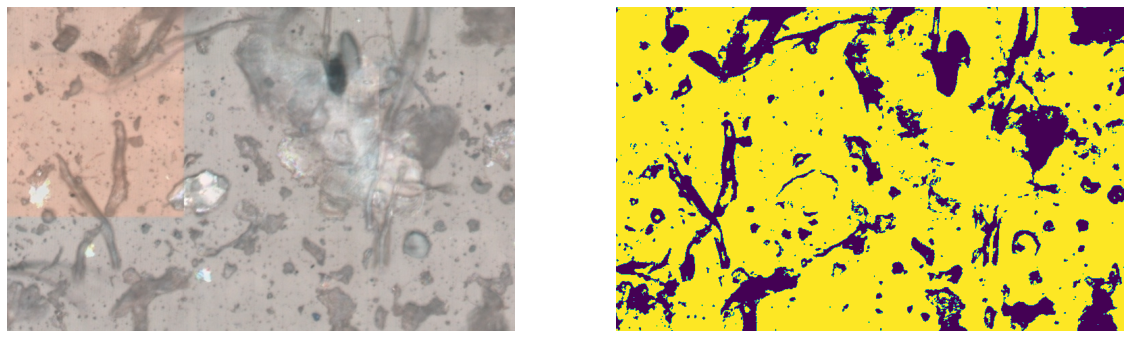

In [12]:
# Test with thresholding first

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]

imaget = cv2.imread("./data/220324_752x480-Sample_1.jpg")
imagetgray = cv2.cvtColor(imaget,cv2.COLOR_BGR2GRAY)
ret,thresh4 = cv2.threshold(imagetgray,150,255,cv2.THRESH_BINARY)

#plt.imshow(thresh4,'thresh')


# Spawn a new figure
plt.figure()
# Show the first image on the left column
plt.subplot(1,2,1)
plt.imshow(imaget)
# Turn off axis numbering
plt.axis('off')

# Show the second image on the right column
plt.subplot(1,2,2)
plt.imshow(thresh4)
# Turn off the axis numbering
plt.axis('off')

# Show the figure
plt.show()


In [13]:
# This is a mix, mainly from GEPARD and is only a small piece... the whole thing is too complex

cfg = get_cfg()
        
# Load model config and pre-trained model
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "../POC_Imptox_tab/neuralnet/neuralNetWeights.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.DEVICE = "cpu"
        
predictor = DefaultPredictor(cfg)


def getContoursFromImage(img: np.ndarray):# -> List[np.ndarray]:
    """
    Retrieves a list of contours from the given image. Only outer contours are returned, no contour approximation is done.
    """
    if cv2.__version__ > '3.5':
        contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    else:
        temp, contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    contours = [contours[i] for i in range(len(contours)) if hierarchy[0, i, 3] < 0]  # limit to outer contours
    return contours

def getContoursFromImageWithNeuralNet(colorImg: np.ndarray, minSize: Optional[float], maxSize: Optional[float]) -> List[np.ndarray]:
    """
    Retrieves a list of contours from an image, using the neural net predictor.
    :param colorImg: Colorimage to use
    :param minSize: minimum contour size (px), optional, longest size
    :param maxSize: maximum contour size (px), optional, longest size
    """
    finalcontours: List[np.ndarray] = []
    pred = predictor(colorImg)
    for i in range(len(pred.get('instances'))):
        instance = pred.get('instances')[i]
        binaryMask: np.ndarray = np.array(instance.get('pred_masks'))[0, :, :] * 1
        binaryMask = binaryMask.astype(np.uint8)
        contours = getContoursFromImage(binaryMask)

        newContour: Optional[np.ndarray] = None
        if len(contours) == 1:  # the ideal, expected case
            newContour = contours[0]
        elif len(contours) > 0:  # sometimes the NN produces small fragments in an instance, sometimes the cnt function returns none...
            areas: List[int] = [cv2.contourArea(cnt) for cnt in contours]
            newContour = contours[np.argmax(areas)]  # we take the largest contour

        if newContour is not None:
            if minSize is not None and maxSize is not None:
                size, _, _ = 6, 6, 6 #getContourStats(newContour)
                if size < minSize or size > maxSize:
                    newContour = None

        if newContour is not None:
            finalcontours.append(newContour)

    return finalcontours










image = cv2.imread("./data/fake.BMP")
imagegray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_c = getContoursFromImage(imagegray)

print(type(imagegray))
# <class 'numpy.ndarray'>

print(imagegray.shape)
# (225, 400, 3)

print(imagegray.dtype)

# Now show the image
#cv2.imshow('Output', imagegray)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#print(image_c)

getContoursFromImageWithNeuralNet(image, 5, 50)






<class 'numpy.ndarray'>
(480, 752)
uint8


[array([[[276, 274]],
 
        [[275, 275]],
 
        [[274, 275]],
 
        [[273, 275]],
 
        [[272, 276]],
 
        [[271, 277]],
 
        [[270, 277]],
 
        [[269, 278]],
 
        [[269, 279]],
 
        [[268, 280]],
 
        [[268, 281]],
 
        [[267, 282]],
 
        [[267, 283]],
 
        [[267, 284]],
 
        [[266, 285]],
 
        [[265, 286]],
 
        [[264, 287]],
 
        [[264, 288]],
 
        [[263, 289]],
 
        [[263, 290]],
 
        [[262, 291]],
 
        [[262, 292]],
 
        [[262, 293]],
 
        [[262, 294]],
 
        [[262, 295]],
 
        [[262, 296]],
 
        [[262, 297]],
 
        [[262, 298]],
 
        [[262, 299]],
 
        [[261, 300]],
 
        [[261, 301]],
 
        [[262, 302]],
 
        [[262, 303]],
 
        [[262, 304]],
 
        [[262, 305]],
 
        [[262, 306]],
 
        [[262, 307]],
 
        [[262, 308]],
 
        [[262, 309]],
 
        [[262, 310]],
 
        [[262, 311]],
 
        [[262, 3

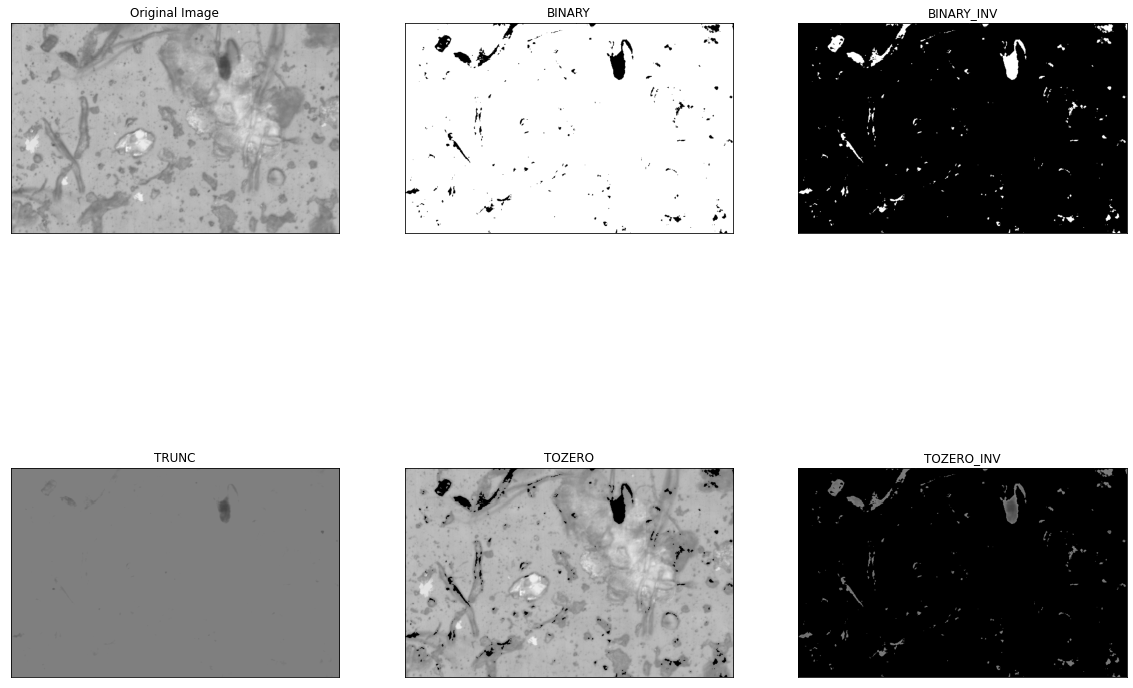

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]

# Get contours and display image
# https://stackoverflow.com/questions/28677544/how-do-i-display-the-contours-of-an-image-using-opencv-python


im = cv2.imread("./data/220324_752x480-Sample_1.jpg")


imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)


img = cv2.imread('./data/220324_752x480-Sample_1.jpg',0)

ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


In [ ]:
ret,thresh = cv2.threshold(imgray,127,255,0)

In [ ]:
## Step #1 - Detect contours using both methods on the same image
contours1, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
contours2, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
### Step #2 - Reshape to 2D matrices
contours1 = contours1[0].reshape(-1,2)
contours2 = contours2[0].reshape(-1,2)

In [ ]:
### Step #3 - Draw the points as individual circles in the image
img1 = im.copy()
img2 = im.copy()

for (x, y) in contours1:
    cv2.circle(img1, (x, y), 1, (255, 0, 0), 3)

for (x, y) in contours2:
    cv2.circle(img2, (x, y), 1, (255, 0, 0), 3)

In [51]:
out = np.hstack([img1, img2])

# Now show the image
cv2.imshow('Output', out)
cv2.waitKey(0)
cv2.destroyAllWindows()

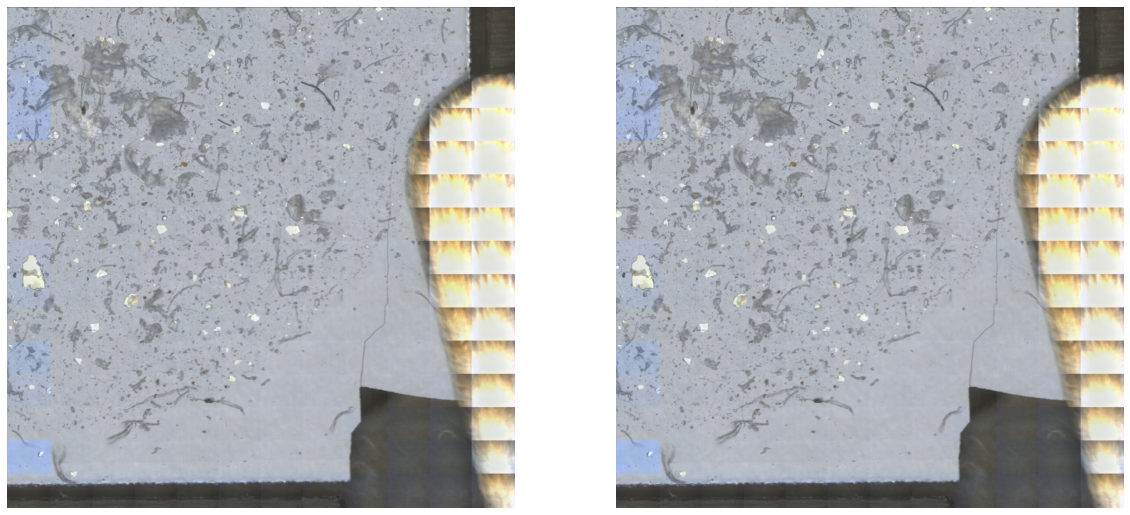

In [49]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]



# Spawn a new figure
plt.figure()
# Show the first image on the left column
plt.subplot(1,2,1)
plt.imshow(img1[:,:,::-1])
# Turn off axis numbering
plt.axis('off')

# Show the second image on the right column
plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
# Turn off the axis numbering
plt.axis('off')

# Show the figure
plt.show()

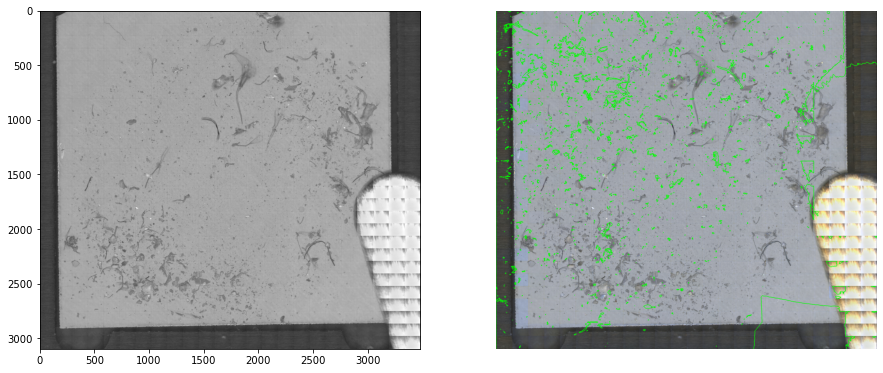

In [62]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]

import numpy as np
import cv2

im2 = cv2.imread('./data/testme2.jpg')
imgray2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
ret2,thresh2 = cv2.threshold(imgray,127,127,0)
contours2, hierarchy2 = cv2.findContours(thresh2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(im2, contours2, -1, (0,255,0), 3)
#cv2.imshow("title", im2)
#cv2.imshow("title", imgray2)
#cv2.waitKey()

# Spawn a new figure
plt.figure()
# Show the first image on the left column
plt.subplot(1,2,1)
plt.imshow(imgray2, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im2[:,:,::-1])
# Turn off the axis numbering
plt.axis('off')

# Show the figure
plt.show()